# Advanced Topics in Machine Learning - Assignment 0
## Task 2: Understanding Vision Transformers (ViT)

This notebook explores the inner workings of a pre-trained Vision Transformer (ViT). We will perform image classification, visualize attention maps, test robustness to masking, and compare different feature pooling methods for downstream tasks.

### Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor, ViTModel

os.environ["TQDM_NOTEBOOK"] = "0"
import io

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1. Using a Pre-trained ViT for Image Classification
We load a pre-trained ViT model and run it on 3 sample images. For each image, we will:
1.  Classify the image.
2.  Visualize the model's attention map.
3.  Test the model's robustness to random and structured masking.

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing Image 1 ---


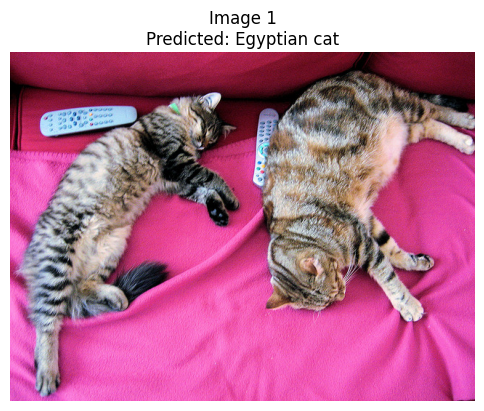

Prediction: Egyptian cat

--- Processing Image 2 ---


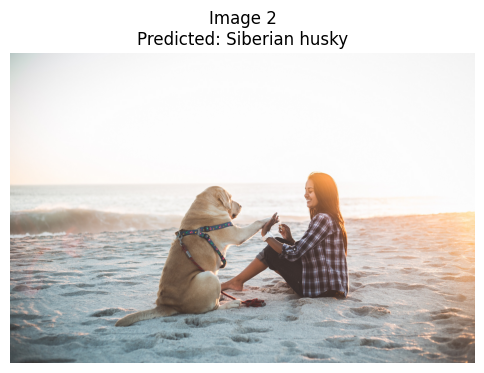

Prediction: Siberian husky

--- Processing Image 3 ---


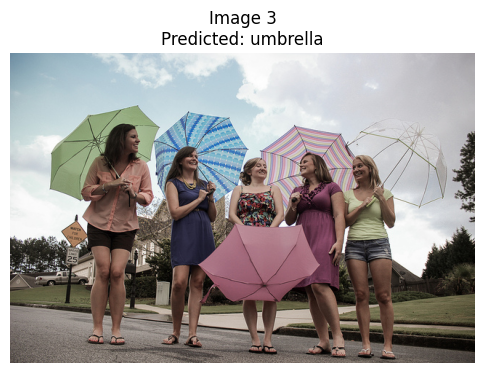

Prediction: umbrella


In [2]:
model_name = "google/vit-base-patch16-224"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name).to(device)

urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",  # Cats
    "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg",  # Dog
    "http://images.cocodataset.org/val2017/000000281759.jpg",  # Umbrella
]

images = []
predictions = []

for i, url in enumerate(urls):
    print(f"\n--- Processing Image {i+1} ---")
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
        images.append(image)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        continue

    inputs = image_processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(inputs["pixel_values"])
    
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    
    if model.config.id2label:
        predicted_class = model.config.id2label[predicted_class_idx]
    else:
        predicted_class = f"Class index: {predicted_class_idx}"
    
    predictions.append(predicted_class)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Image {i+1}\nPredicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    print(f"Prediction: {predicted_class}")

### 2. Visualizing Patch Attention
We extract the attention weights from the final layer, focusing on the special `[CLS]` token to see which parts of the image were most influential for the classification decision.


--- Attention Analysis for Image 1 ---


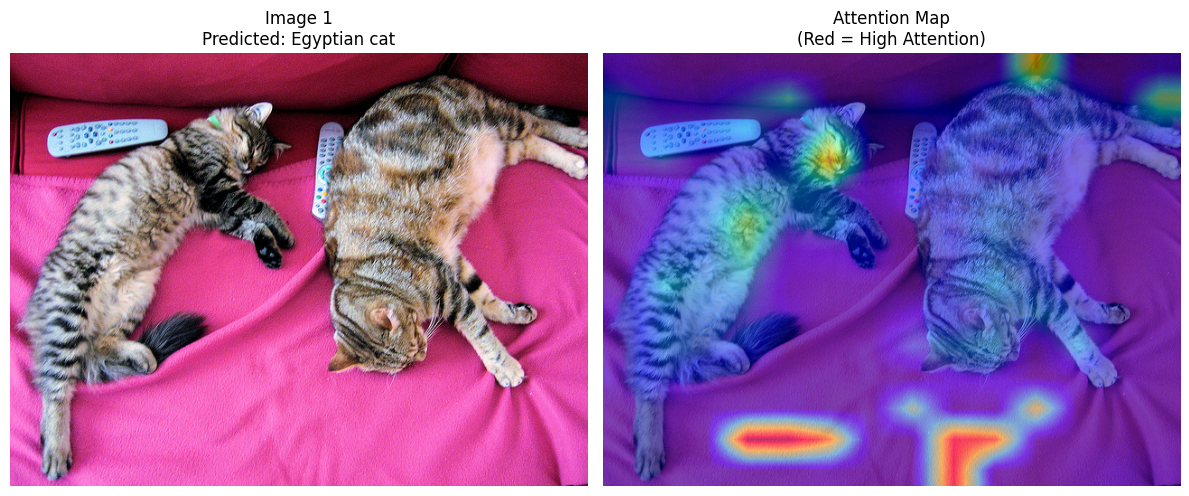


--- Attention Analysis for Image 2 ---


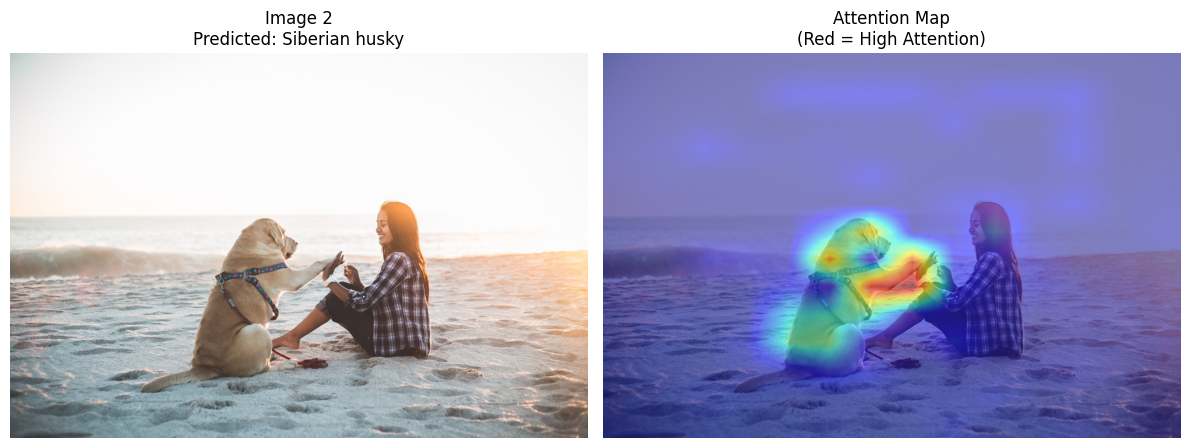


--- Attention Analysis for Image 3 ---


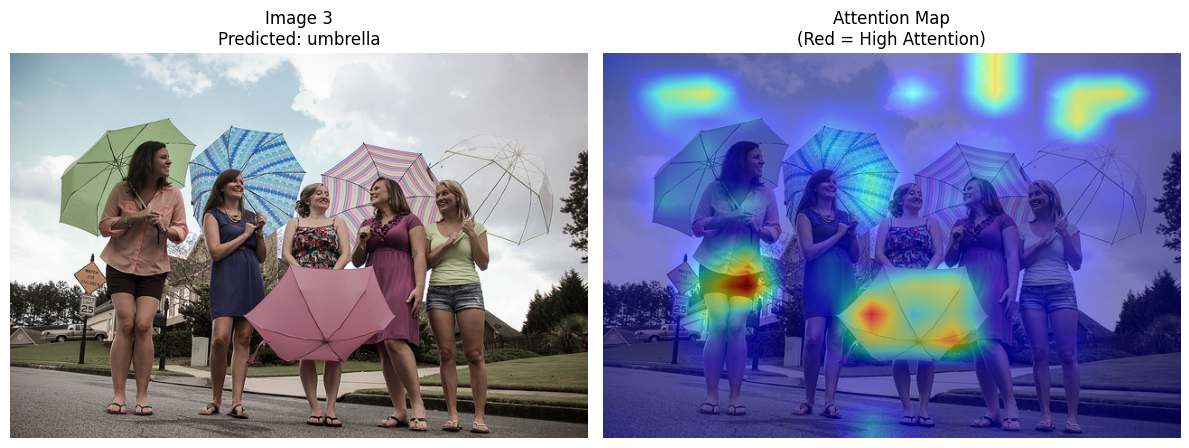

In [3]:
model_with_attention = ViTForImageClassification.from_pretrained(
    model_name, output_attentions=True
).to(device)

for i, (image, prediction) in enumerate(zip(images, predictions)):
    print(f"\n--- Attention Analysis for Image {i+1} ---")
    
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs["pixel_values"]
    
    with torch.no_grad():
        outputs = model_with_attention(pixel_values, output_attentions=True)
    
    attention_weights = outputs.attentions[-1].squeeze(0).cpu()
    avg_attention = torch.mean(attention_weights, dim=0) # average over all heads
    
    cls_attention = avg_attention[0, 1:]  # first token is CLS, exclude attention to itself
    
    # Reshape attention to spatial grid
    num_patches_side = int(np.sqrt(cls_attention.shape[0]))
    attention_map = cls_attention.reshape(num_patches_side, num_patches_side)
    
    # Resize attention map to match image dimensions
    attention_map_resized = torch.nn.functional.interpolate(
        attention_map.unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode='bilinear',
        align_corners=False
    ).squeeze().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title(f"Image {i+1}\nPredicted: {prediction}")
    ax1.axis('off')
    
    ax2.imshow(image)
    ax2.imshow(attention_map_resized, cmap='jet', alpha=0.5)
    ax2.set_title(f"Attention Map\n(Red = High Attention)")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

### 4. How Robust is ViT to Missing Patches?
We test the model's robustness by masking parts of the input image and observing the effect on its prediction. We will try two strategies: masking random patches and masking a structured region (the center).


Testing robustness with Image 1 (Original prediction: Egyptian cat)
Processed image dimensions: 224x224
Number of patches: 14x14 = 196
Center masking region: rows 56-168, cols 56-168


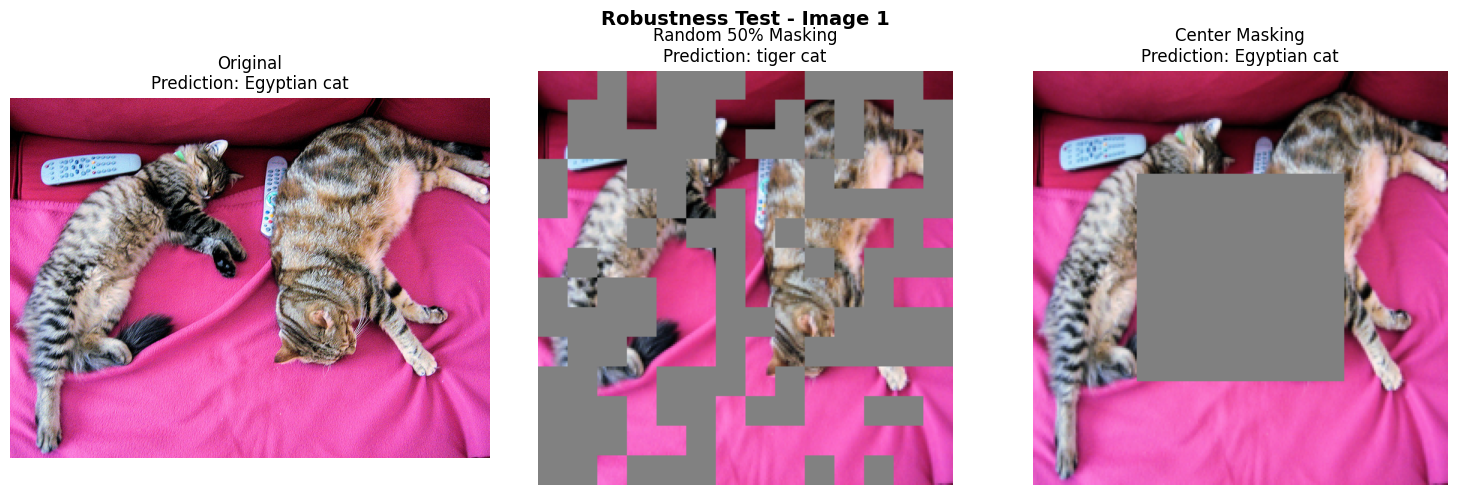


Robustness Results for Image 1:
  Original: Egyptian cat
  Random masking: tiger cat
  Center masking: Egyptian cat
  ✗ NOT robust to random masking (prediction changed)
  ✓ Robust to center masking

Testing robustness with Image 2 (Original prediction: Siberian husky)
Processed image dimensions: 224x224
Number of patches: 14x14 = 196
Center masking region: rows 56-168, cols 56-168


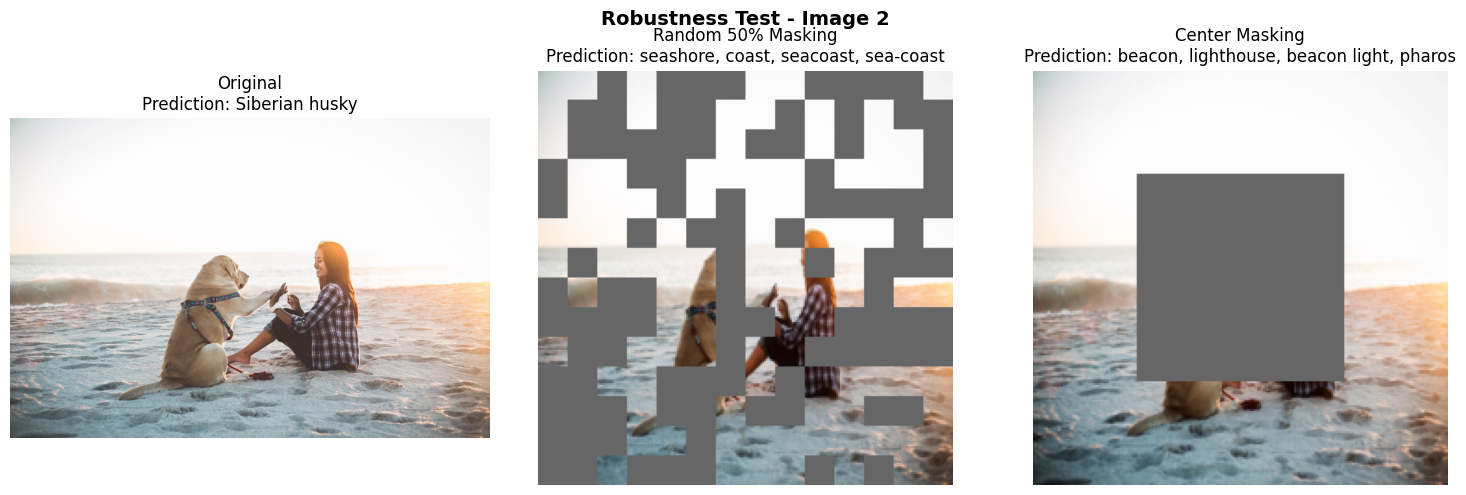


Robustness Results for Image 2:
  Original: Siberian husky
  Random masking: seashore, coast, seacoast, sea-coast
  Center masking: beacon, lighthouse, beacon light, pharos
  ✗ NOT robust to random masking (prediction changed)
  ✗ NOT robust to center masking (prediction changed)

Testing robustness with Image 3 (Original prediction: umbrella)
Processed image dimensions: 224x224
Number of patches: 14x14 = 196
Center masking region: rows 56-168, cols 56-168


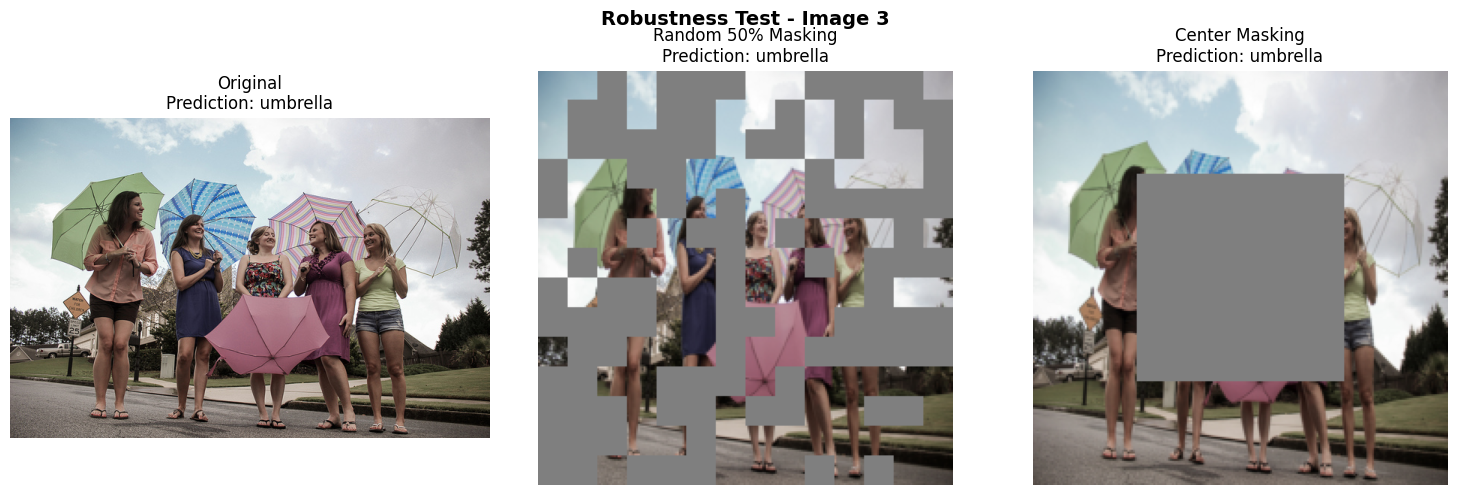


Robustness Results for Image 3:
  Original: umbrella
  Random masking: umbrella
  Center masking: umbrella
  ✓ Robust to random masking
  ✓ Robust to center masking


In [4]:
def predict_and_show(pixel_tensor, title, ax):
    with torch.no_grad():
        logits = model(pixel_tensor.to(device)).logits
    pred_idx = logits.argmax(-1).item()
    
    if model.config.id2label:
        prediction = model.config.id2label[pred_idx]
    else:
        prediction = f"Class index: {pred_idx}"
    
    img_to_show = pixel_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    
    # normalise
    if img_to_show.max() > img_to_show.min():
        img_to_show = (img_to_show - img_to_show.min()) / (img_to_show.max() - img_to_show.min())
    
    ax.imshow(img_to_show)
    ax.set_title(f"{title}\nPrediction: {prediction}")
    ax.axis('off')
    
    return prediction

for i, (test_image, original_prediction) in enumerate(zip(images, predictions)):
    print(f"\n{'='*50}")
    print(f"Testing robustness with Image {i+1} (Original prediction: {original_prediction})")
    print(f"{'='*50}")
    
    inputs = image_processor(images=test_image, return_tensors="pt").to(device)
    pixel_values = inputs["pixel_values"]
    
    _, _, img_height, img_width = pixel_values.shape # [batch, channels, height, width]
    patch_size = 16
    num_patches_h = img_height // patch_size
    num_patches_w = img_width // patch_size
    
    print(f"Processed image dimensions: {img_width}x{img_height}")
    print(f"Number of patches: {num_patches_w}x{num_patches_h} = {num_patches_w * num_patches_h}")
    
    np.random.seed(42)
    masked_pixel_values_random = pixel_values.clone()
    num_patches_to_mask = int(0.5 * (num_patches_h * num_patches_w))
    mask_indices = np.random.choice(num_patches_h * num_patches_w, num_patches_to_mask, replace=False)
    
    for idx in mask_indices:
        patch_row = idx // num_patches_w
        patch_col = idx % num_patches_w
        
        row_start = patch_row * patch_size
        row_end = row_start + patch_size
        col_start = patch_col * patch_size
        col_end = col_start + patch_size
        
        masked_pixel_values_random[:, :, row_start:row_end, col_start:col_end] = 0
    
    # centre masking
    masked_pixel_values_center = pixel_values.clone()
    center_h_start = img_height // 4
    center_h_end = 3 * img_height // 4
    center_w_start = img_width // 4
    center_w_end = 3 * img_width // 4
    
    print(f"Center masking region: rows {center_h_start}-{center_h_end}, cols {center_w_start}-{center_w_end}")
    
    masked_pixel_values_center[:, :, center_h_start:center_h_end, center_w_start:center_w_end] = 0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # original image
    ax1.imshow(test_image)
    ax1.set_title(f"Original\nPrediction: {original_prediction}")
    ax1.axis('off')
    
    # masked images
    random_pred = predict_and_show(masked_pixel_values_random, "Random 50% Masking", ax2)
    center_pred = predict_and_show(masked_pixel_values_center, "Center Masking", ax3)
    
    plt.suptitle(f"Robustness Test - Image {i+1}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nRobustness Results for Image {i+1}:")
    print(f"  Original: {original_prediction}")
    print(f"  Random masking: {random_pred}")
    print(f"  Center masking: {center_pred}")
    
    if random_pred == original_prediction:
        print(f"  ✓ Robust to random masking")
    else:
        print(f"  ✗ NOT robust to random masking (prediction changed)")
        
    if center_pred == original_prediction:
        print(f"  ✓ Robust to center masking")
    else:
        print(f"  ✗ NOT robust to center masking (prediction changed)")

### 5. Compare Linear Probes: CLS Token vs. Mean of Patch Tokens

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# base ViT model without the classification head
base_model = ViTModel.from_pretrained(model_name).to(device)
base_model.eval()

def extract_features(dataloader):
    features_cls = []
    features_mean = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Extracting Features"):
            inputs = inputs.to(device)
            outputs = base_model(inputs)
            
            cls_token_output = outputs.last_hidden_state[:, 0, :].cpu() # first token of last hidden state
            features_cls.append(cls_token_output)
            
            mean_pool_output = outputs.last_hidden_state[:, 1:, :].mean(dim=1).cpu() # mean of patch tokens (exclude CLS token)
            features_mean.append(mean_pool_output)
            
            labels_list.append(labels.cpu())
            
    return torch.cat(features_cls), torch.cat(features_mean), torch.cat(labels_list)

print("\nExtracting features from CIFAR-10...")
X_train_cls, X_train_mean, y_train = extract_features(trainloader)
X_test_cls, X_test_mean, y_test = extract_features(testloader)

print(f"Feature shapes:")
print(f"CLS features: {X_train_cls.shape}")
print(f"Mean pooled features: {X_train_mean.shape}")

# Linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        return self.linear(x)

def train_and_evaluate(X_train, y_train, X_test, y_test, feature_type, num_classes=10):
    print(f"\nTraining linear probe on {feature_type} features...")
    
    input_dim = X_train.shape[1]
    probe = LinearProbe(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe.parameters(), lr=0.001)
    
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    # Training
    probe.train()
    for epoch in range(20):
        epoch_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = probe(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss/len(loader):.4f}")
    
    # Evaluation
    probe.eval()
    with torch.no_grad():
        outputs = probe(X_test.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total = y_test.size(0)
        correct = (predicted == y_test.to(device)).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

accuracy_cls = train_and_evaluate(X_train_cls, y_train, X_test_cls, y_test, "CLS token")
accuracy_mean = train_and_evaluate(X_train_mean, y_train, X_test_mean, y_test, "mean pooled")

print(f"\n{'='*50}")
print(f"FINAL RESULTS:")
print(f"{'='*50}")
print(f"Accuracy with CLS token features: {accuracy_cls:.2f}%")
print(f"Accuracy with mean-pooled patch token features: {accuracy_mean:.2f}%")
print(f"{'='*50}")

if accuracy_cls > accuracy_mean:
    print(f"CLS token features perform better by {accuracy_cls - accuracy_mean:.2f} percentage points")
elif accuracy_mean > accuracy_cls:
    print(f"Mean pooled features perform better by {accuracy_mean - accuracy_cls:.2f} percentage points")
else:
    print("Both feature types perform equally well")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Extracting features from CIFAR-10...


Extracting Features: 100%|██████████| 157/157 [00:12<00:00, 13.00it/s]


Feature shapes:
CLS features: torch.Size([50000, 768])
Mean pooled features: torch.Size([50000, 768])

Training linear probe on CLS token features...
Epoch 0, Loss: 0.1755
Epoch 5, Loss: 0.0588
Epoch 10, Loss: 0.0449
Epoch 15, Loss: 0.0372

Training linear probe on mean pooled features...
Epoch 0, Loss: 0.1946
Epoch 5, Loss: 0.0563
Epoch 10, Loss: 0.0424
Epoch 15, Loss: 0.0347

FINAL RESULTS:
Accuracy with CLS token features: 96.48%
Accuracy with mean-pooled patch token features: 96.94%
Mean pooled features perform better by 0.46 percentage points
